In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
from misc import *
from scipy.signal import stft, blackman, hann, chirp, find_peaks
from math import pi
import pandas as pd


datapath = './../../audio/reduzidas'

In [11]:
wlen = 512
win = hann(wlen)
nfft = 1024
threshold = 14
fs, audio = read_audio('../../../../lps/SonarAnalysis/ExemplosLofar/vsine.wav')
f, t, spec = stft(audio, fs, win, wlen, wlen/2, nfft)
power = processSpec(spec, win, wlen, threshold)
# spec = abs(spec)


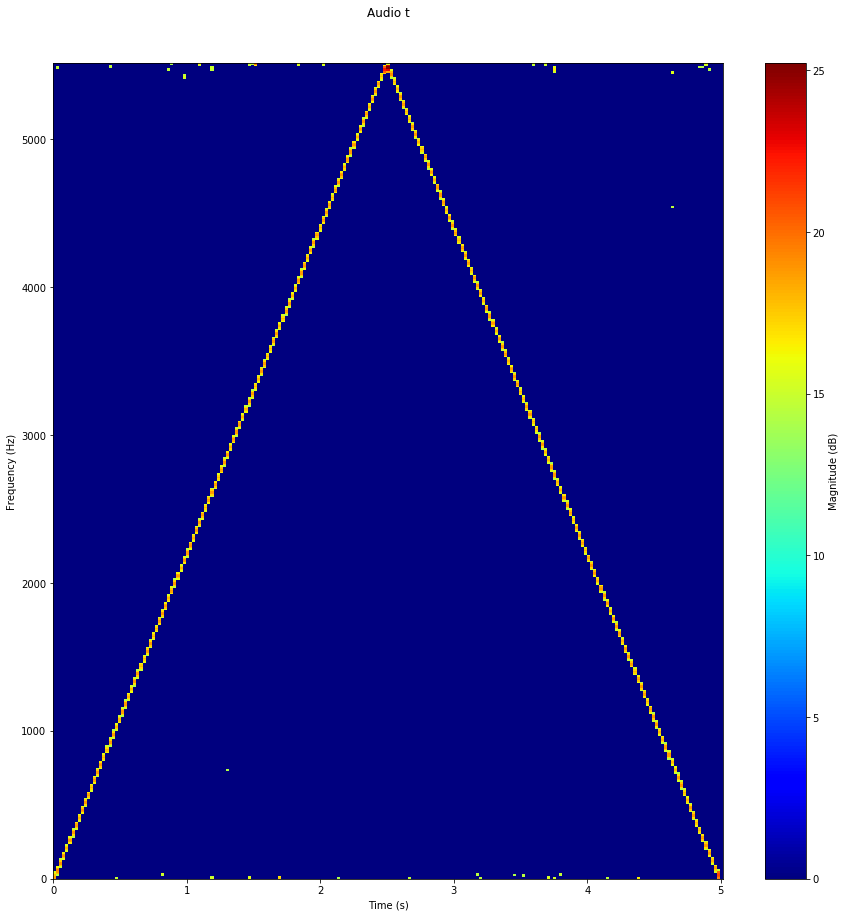

In [12]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,15))
plt.subplots_adjust(hspace=0.45)
# power = processSpec(spec, wlen, 0)
plot_spec(power, t, f, "Audio teste", ax)


In [13]:

indexes = np.where(power>0)
# indexes, peak_properties = np.apply_along_axis(lambda x: find_peaks(x, height=5), axis=0, arr=power)
# peak_amplitudes = [properties['peak_heights'] for properties in peak_properties]
# peak_frequencies = map(lambda x: f[x], peak_indexes)


In [14]:
# def mark_tracks(peak_indexes, freq_mat, ampl_mat):
#     tracks = np.array([], dtype=object)
    
#     def match_track(peak_freq, peak_ampl, i_frame, tracks):
#         mask = np.array([track.matchFrequency(peak_freq,2) for track in tracks], dtype=int)
#         indexes = np.nonzero(mask)[0]
#         if indexes.size == 0:
#             track = Track(i_frame, peak_freq, peak_ampl)
#             tracks = np.append(tracks, track)
#             return tracks
#         print ('F: %f A: %f, Fr: %i' % (peak_freq,peak_ampl, i_frame))
#         tracks[indexes[0]].append_frame(peak_freq,peak_ampl,i_frame)
#         return tracks  #criterio de desempate: pega o primeiro  
        
#     def compare_tracks(peak_frequencies, peak_amplitudes, tracks, i_frame):
# #         track_pair = np.array([match_track(peak_freq, peak_ampl, i_frame) 
# #                                       for peak_freq, peak_ampl in 
# #                                zip(peak_frequencies, peak_amplitudes)])
#         #         ind = match_tracks(peak_frequencies)
#         for peak_freq, peak_ampl in zip(peak_frequencies, peak_amplitudes):
#             tracks = match_track(peak_freq, peak_ampl, i_frame, tracks)
# #         for ind, winner_track in track_pair:
# #             if ind != -1:
# #                 tracks[ind] = winner_track
# #         ind, winner_tracks = zip(*track_pair)
# #         winner_tracks = winner_tracks[ind  > 0]
# #         ind = ind[ind  > 0]
# #         tracks[ind] = winner_tracks
# #         winner_tracks = tracks[ind]
# #         if winner_tracks.size > 0:
# #             tracks[ind] = [track.append_frame(freq, ampl, i_frame) 
# #                             for track, freq, ampl in zip(tracks[ind], 
# #                                                          peak_frequencies[ind], 
# #                                                          peak_amplitudes[ind])]
        
# #         ind, _ = zip(*track_pair)
# #         print ind
# #         new_tracks_mask = np.ones_like(peak_frequencies, dtype=bool)
# #         new_tracks_mask[ind] = False
        
# #         new_tracks = np.array([Track(i_frame, freq, ampl) for freq, ampl in
# #                               zip(peak_frequencies[new_tracks_mask], 
# #                                   peak_amplitudes[new_tracks_mask])])
# #         tracks = np.append(tracks, new_tracks)
#         return tracks
    
#     for i_frame, (peak_frequencies, peak_amplitudes) in enumerate(zip(freq_mat, ampl_mat)):
#         tracks = compare_tracks(peak_frequencies, peak_amplitudes, tracks, i_frame)
    
#     for track in tracks:
#         track.closeTrack()
#     return tracks

# tracks = mark_tracks(peak_indexes, peak_frequencies, peak_amplitudes)


In [15]:
# from synthesizers import Sinusoidal
# s = Sinusoidal(tracks, 1024, power.shape[1])
# plt.imshow(s.run())

In [16]:
abs_value = np.absolute(power)

In [17]:
listOfCoords = list(zip(indexes[0],indexes[1])) # Item i of this list is the ith spectral peak's 
                                                # frequency index and frame index

listOfTracks = []

for coord in listOfCoords:
    (f_bin, frame_index) = coord # Frames which belong to the frame we are analising
    if (frame_index==0) :
        x = Track(0,f[f_bin],power[coord]) 
        listOfTracks.append(x)

# arr = np.array(listOfCoords)
df = pd.DataFrame(listOfCoords,columns=['freq_bin','time_frame'])
r = (df[df.time_frame == 1])
r = (df[df.time_frame == 1]).to_numpy().tolist()

In [18]:
import copy
freq_dist_thresh = 0.1


for j in range(1,len(t)-1):
    if j % 10 == 0:
        print ("Frame %i" % j)
#     peaks_in_frame = (arr[:, np.hsplit(arr,2) == j]).tolist()
    peaks_in_frame = (df[df.time_frame == j]).to_numpy().tolist()
    end = False
    while not(end) :
        list_of_pairs = []
        for peak in peaks_in_frame :
            (win,dif) = evaluate_closest_track(peak,listOfTracks,freq_dist_thresh,j,f)
#             (win,dif) = evaluate_closest_track(peak[0],listOfTracks,freq_dist_thresh,j,f)
            k = (win,dif,peak)
            list_of_pairs.append(k)
        n_list_of_pairs = copy.deepcopy(list_of_pairs)
        for value in n_list_of_pairs :
            if (value[0] == -1): 
                x = Track(j,f[value[2]],abs_value[tuple(value[2])]) # a new track is born
                listOfTracks.append(x) #append track
                list_of_pairs.remove(value)
                peaks_in_frame.remove(value[2]) #no need to run it again for that peak
            else :
                list_of_recurrencies = list(filter(lambda x : x[0] == value[0],n_list_of_pairs))
                if (len(list_of_recurrencies) > 1) : # We are not the only ones who chose this track
                    dists = list(map(lambda x : x[1],list_of_recurrencies))
                    if (value[1] == min(dists) and (len(listOfTracks[value[0]].getFrequency()) + listOfTracks[value[0]].getInitialFrame() <= j)):
                        listOfTracks[value[0]].frequency.append(f[((value[2])[0])])
                        listOfTracks[value[0]].amplitude.append((abs_value[tuple(value[2])]))
                        peaks_in_frame.remove(value[2])
                        list_of_pairs.remove(value)
                else :
                    listOfTracks[value[0]].frequency.append(f[(value[2][0])])
                    listOfTracks[value[0]].amplitude.append((abs_value[tuple(value[2])]))
                    list_of_pairs.remove(value)
                    peaks_in_frame.remove(value[2])
        
        end = (len(peaks_in_frame) == 0)            
    for track in listOfTracks:
         # Track wasnt assigned any peak on this frame
        if ((track.getFinalFrame() < 0) and (len(track.getFrequency()) + track.getInitialFrame() <= j)):
            track.setFinalFrame(j-1) # End of the track
        elif ((track.getFinalFrame() < 0) and (j==2464)): # No more frames to go:
            track.setFinalFrame(j) # End of the track

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [30]:
listOfTracks[0].frequency

[array([10.76660156, 53.83300781])]

In [15]:
from synthesizers import Sinusoidal
s = Sinusoidal(listOfTracks, 1024, power.shape[1])
plt.imshow(s.run())

ValueError: all the input arrays must have same number of dimensions